In [1]:
from bucket_model import BucketModel
from bucket_model_optimizer import BucketModelOptimizer
from data_processing import preprocess_data, train_validate_split

from bucket_model_plotter import plot_water_balance, plot_Q_Q, plot_ECDF, plot_KDE, plot_monthly_boxplot, plot_timeseries, plot_parameter_kde

import pandas as pd

In [2]:
path_to_file = '/Users/cooper/Desktop/bucket-model/data/GSTEIGmeteo.txt'
output_destination = '/Users/cooper/Desktop/bucket-model/data/GSTEIGmeteo.csv'
catchment_area = 384.2 # km^2

data = preprocess_data(path_to_file=path_to_file, catchment_area=catchment_area)
train_data, validate_data = train_validate_split(data, train_size=0.8)


train_data

,day,P_mix,T_max,T_min,Q
date,,,,,
1986-01-01,1,2.5,-2.5,-11.6,0.512733
1986-01-02,2,0.2,2.6,-10.7,0.537470
1986-01-03,3,4.3,2.2,-5.3,0.532972
1986-01-04,4,3.4,-4.0,-12.9,0.526226
1986-01-05,5,3.6,1.9,-13.3,0.526226
...,...,...,...,...,...
1997-10-14,287,1.4,0.4,-3.1,2.945966
1997-10-15,288,2.2,2.4,-3.4,2.428735
1997-10-16,289,0.7,5.3,1.0,2.428735


In [3]:
# Initialize the BucketModel with initial parameter guesses
bucket = BucketModel(k=0.5, S_max=20, fr=0.14, rg=15.15, gauge_adj=0.05)  # 5% gauge adjustment
bucket.set_catchment_properties(0.5/100, 1638, 2035, 0, 46.9)

# Initialize the BucketModelOptimizer with the BucketModel instance and observed data
optimizer = BucketModelOptimizer(model=bucket, training_data=train_data, validation_data=validate_data)

# Optionally, set additional optimization options, like optimization method, parameter bounds, etc.
bounds = {'k': (0.1, 1), 'S_max': (10, 50), 'fr': (0.1, 0.3), 'rg': (5, 20), 'gauge_adj': (0, 0.15)}
optimizer.set_options(method='n-folds', bounds=bounds, folds=10)

model_performance = optimizer.score_model(metrics=['nse', 'rmse', 'kge', 'pbias', 'log_nse'])
model_performance

{'training': {'nse': 0.588,
  'rmse': 2.542,
  'kge': 0.576,
  'pbias': 28.0,
  'log_nse': 0.625},
 'validation': {'nse': 0.533,
  'rmse': 2.769,
  'kge': 0.592,
  'pbias': 29.515,
  'log_nse': 0.351}}

In [4]:
calibrated_parameters, parameter_df = optimizer.calibrate()

       k   S_max     fr      rg  gauge_adj
0  0.575  24.126  0.100  15.664      0.150
1  0.992  25.600  0.100  18.344      0.150
2  0.574  24.527  0.123  15.677      0.150
3  0.522  25.295  0.162  15.086      0.149
4  0.603  32.134  0.120  16.824      0.150
5  0.501  28.812  0.133   6.225      0.150
6  0.559  43.417  0.122  12.261      0.150
7  0.606  24.910  0.122  17.263      0.150
8  0.606  18.321  0.120  17.654      0.150
9  0.490  24.437  0.127   7.131      0.150


/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

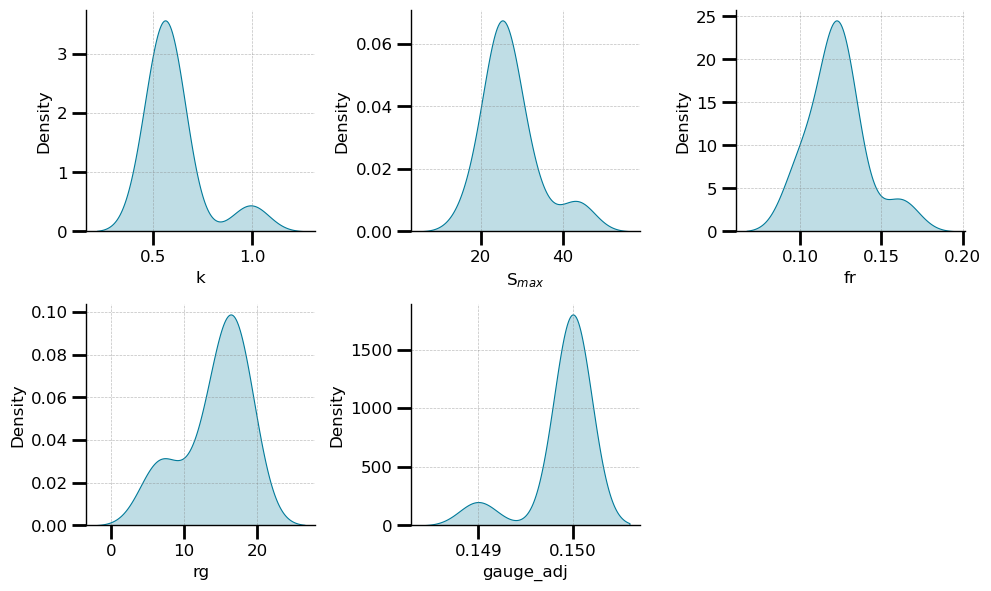

In [5]:
plot_parameter_kde(parameter_df, bounds=bounds)

In [6]:
calibrated_parameters

{'k': 0.606, 'S_max': 18.321, 'fr': 0.12, 'rg': 17.654, 'gauge_adj': 0.15}

In [7]:
calibrated_model = optimizer.model
calibrated_model_perfromance = optimizer.score_model(metrics=['nse', 'rmse', 'kge', 'pbias', 'log_nse'])
calibrated_model_perfromance

{'training': {'nse': 0.626,
  'rmse': 2.421,
  'kge': 0.706,
  'pbias': 19.728,
  'log_nse': 0.582},
 'validation': {'nse': 0.601,
  'rmse': 2.558,
  'kge': 0.696,
  'pbias': 23.728,
  'log_nse': 0.376}}

In [8]:
results = calibrated_model.run(data)

In [9]:
results

,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip
date,,,,,,,,,,
1986-01-01,0.172563,0.000000,9.036994,269.526321,24.264437,55.405808,0.00000,0.000000,2.875000,2.875
1986-01-02,0.214592,0.000000,7.769711,269.745686,24.060480,47.636097,0.00000,0.010635,0.219365,0.230
1986-01-03,0.255763,0.000000,6.680143,274.548929,23.946474,40.955955,0.00000,0.141757,4.803243,4.945
1986-01-04,0.153891,0.000000,5.743368,278.458929,23.792584,35.212587,0.00000,0.000000,3.910000,3.910
1986-01-05,0.188680,0.000000,4.937959,282.598929,23.603904,30.274628,0.00000,0.000000,4.140000,4.140
...,...,...,...,...,...,...,...,...,...,...
2000-09-26,1.166338,0.564115,6.398304,281.086721,24.437000,41.939396,4.44185,0.000000,0.000000,0.000
2000-09-27,1.111294,0.526777,5.881278,276.938871,24.437000,38.567897,4.14785,0.000000,0.000000,0.000
2000-09-28,1.072360,0.501885,5.408484,272.987021,24.437000,35.537018,3.95185,0.000000,0.000000,0.000


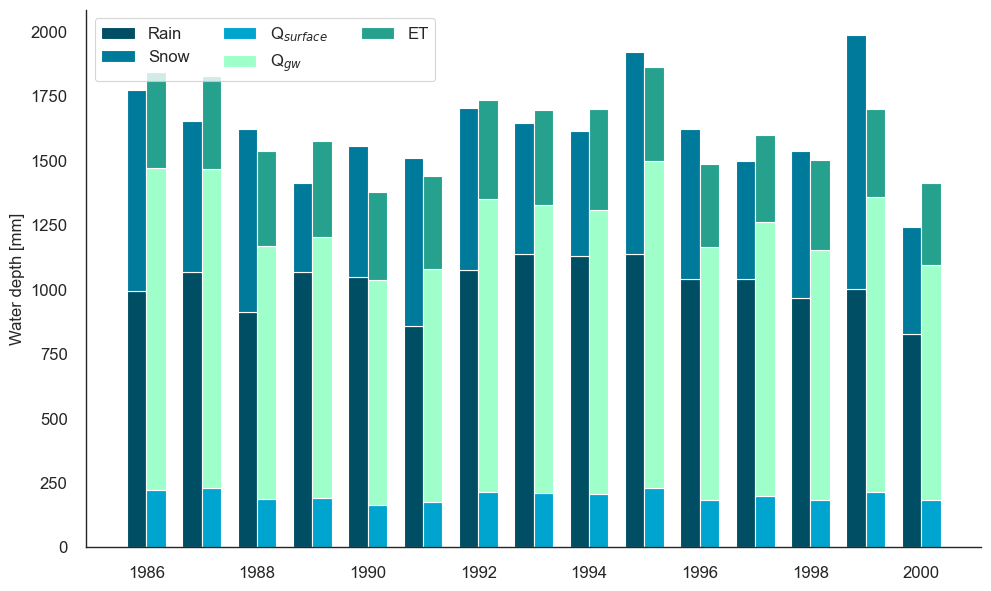

In [10]:
plot_water_balance(results)


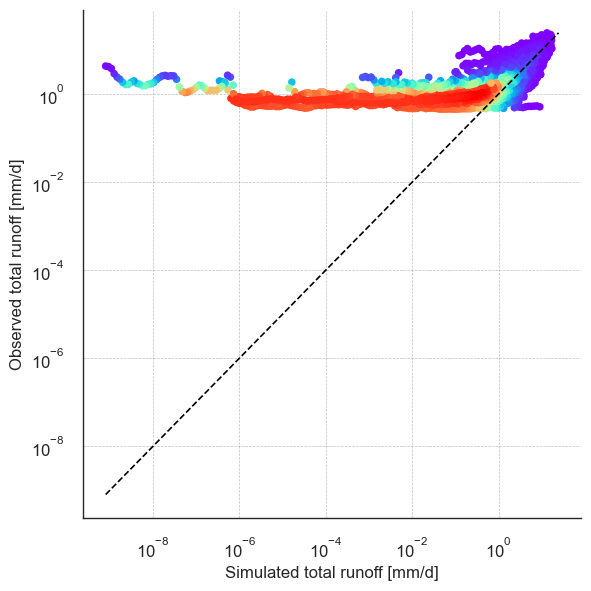

In [11]:
plot_Q_Q(results=results, observed=data, kde=True)

/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


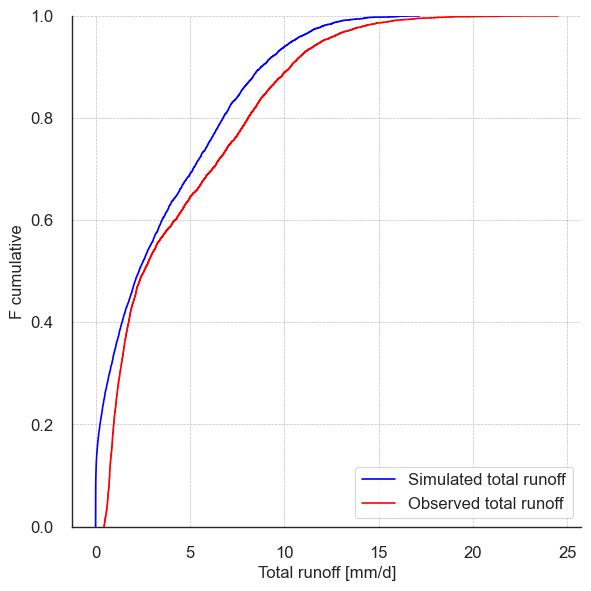

In [12]:
plot_ECDF(results=results, observed=data, palette=['blue', 'red'])

/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


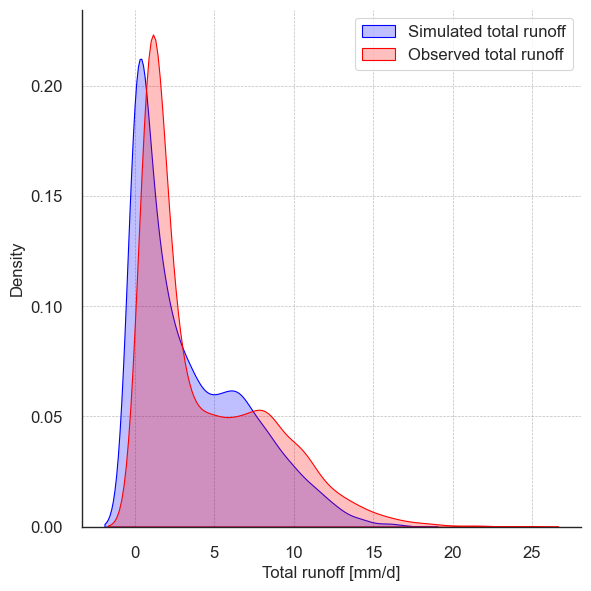

In [13]:
plot_KDE(results=results, observed=data, palette=['blue', 'red'])

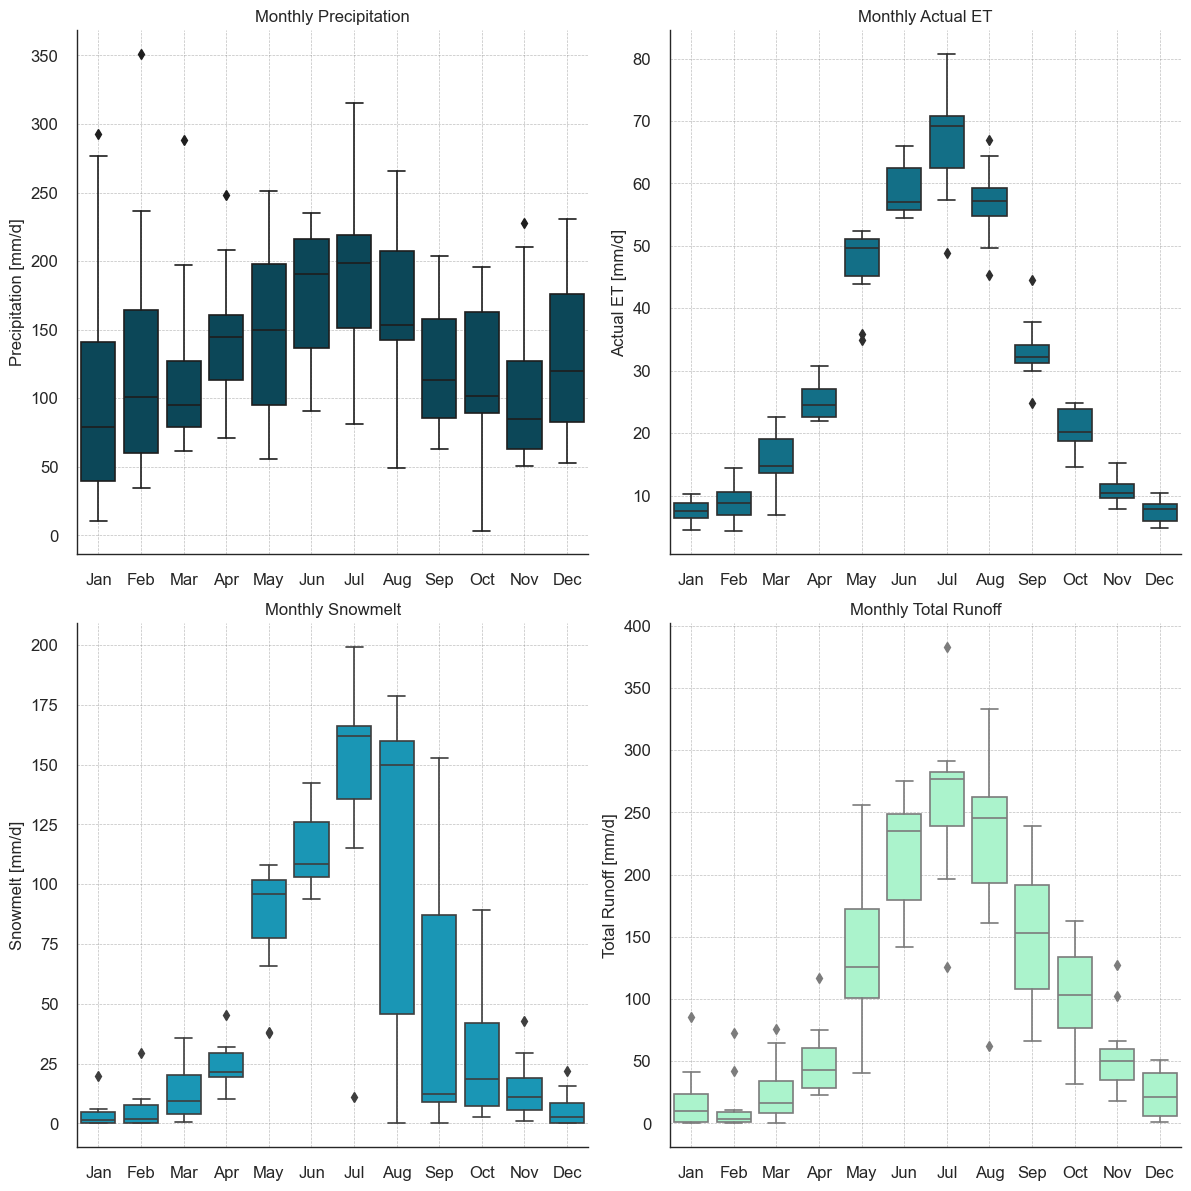

In [14]:
plot_monthly_boxplot(results=results)

/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

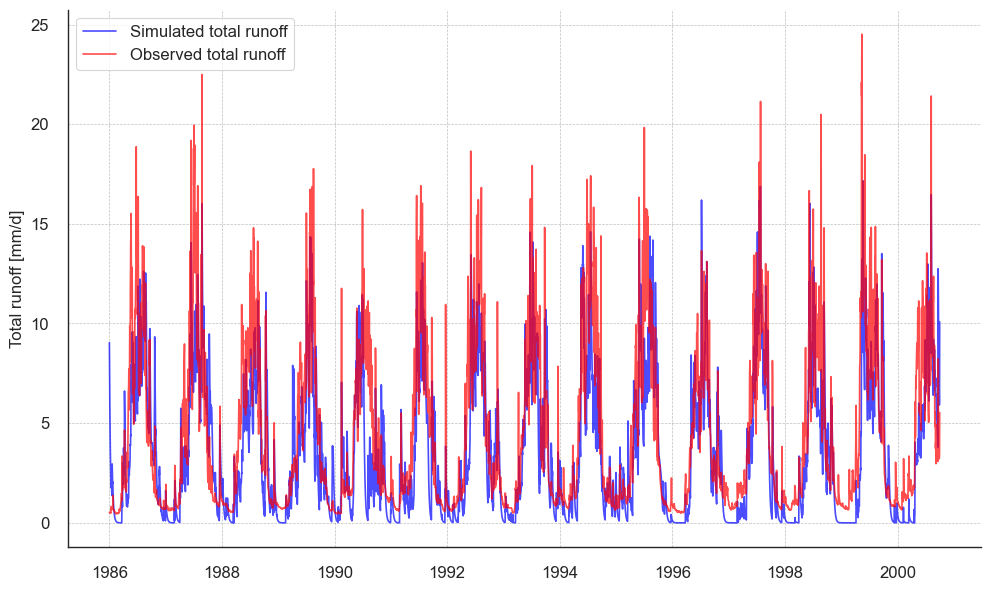

In [15]:
plot_timeseries(results=results, observed=data, start_year='1986', end_year='2000', palette=['blue', 'red'])

/Users/cooper/Desktop/bucket-model/bucket_model_plotter.py:342: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  results_filtered = results_filtered.resample('M').sum()
/Users/cooper/Desktop/bucket-model/bucket_model_plotter.py:343: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  observed_filtered = observed_filtered.resample('M').sum()
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


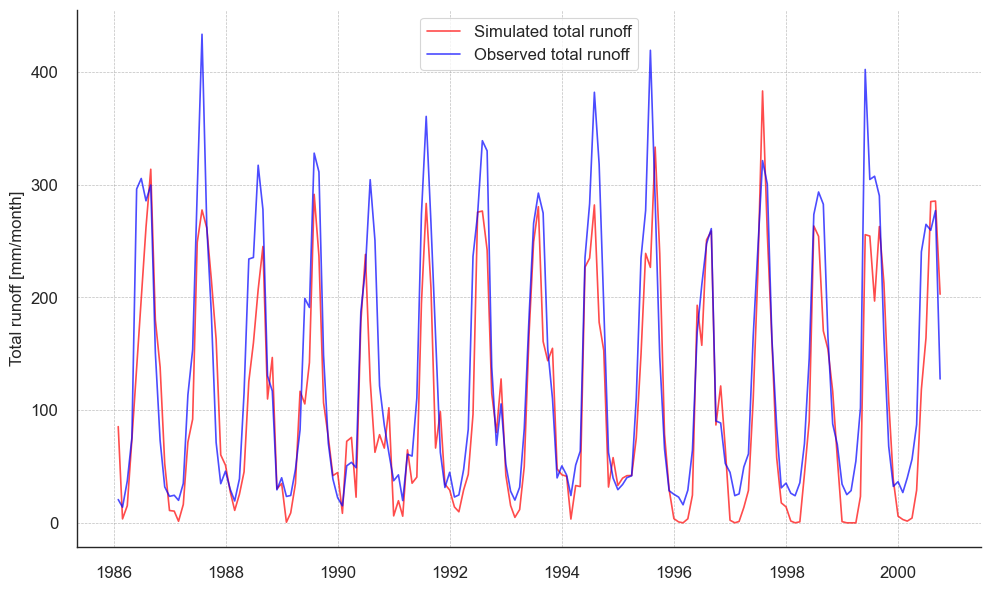

In [16]:
plot_timeseries(results=results, observed=data, start_year='1986', end_year='2000', monthly=True, palette=['red', 'blue'])